In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

from bokeh.io import output_notebook, show
from bokeh.models import Jitter
from bokeh.layouts import column
from bokeh.plotting import figure, show, output_file

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from waveform_processor import ABPWaveformProcessor

In [2]:
store = {}

for raw in listdir('raw/'):
    if (raw != '.DS_Store'):
        store[raw] = pd.HDFStore('raw/{0}'.format(raw))

# Through Trial and Error, Good vs. Bad Raw

# Good
# 'K2ICU_BED18-1447919424.hd5' <-- Best of the bunch. Strong Waveforms and Vitals (AR2 data -- AR2_data.iloc[357000:1071000])
# DELETED 'K2ICU_BED09-1438799806.hd5' <-- Waveform data, not vitals, summary is useless. Waveform data isn't ideal. Poor ecg
# 'K2ICU_BED32-1487763686.hd5' <-- Waveforms data (decent) + vitals (poor) (NO AR DATA)

# Bad
# 'K2ICU_BED25-1458669700.hd5' <-- No vitals or waveform data
# 'K2ICU_BED01-1485531766.hd5' <-- just Vital data, nothing else
# 'K2ICU_BED13-1497121350.hd5' <-- just Vital data, decent heart rate data but not much else
# 'K2ICU_BED07-1493859809.hd5' <-- just Vital data
# 'K2ICU_BED17-1509145105.hd5' <-- just Vitals data, SPO2-% the only column with info
# 'K2ICU_BED01-1472098497.hd5' <-- just Vitals data, Decent HR, ARS2-M might be useful

file = 'K2ICU_BED18-1447919424.hd5'

# print(store.keys())
print(store[file])

waveforms = store[file].select('Waveforms')
vitals = store[file].select('Vitals')
# summary = store[file].select('Summary')

# waves=store.select('Waveforms')

# vitals.head(5)
# summary.head(100)
waveforms.head(5)

<class 'pandas.io.pytables.HDFStore'>
File path: raw/K2ICU_BED18-1447919424.hd5
/Vitals               frame_table  (typ->appendable,nrows->4627,ncols->10,indexers->[index])   
/Waveforms            frame_table  (typ->appendable,nrows->2217600,ncols->11,indexers->[index])


,AR1,AR2,AR3,I,II,III,V,SPO2,CVP1,CVP2,RR
2015-11-19 02:50:25.000000000,NaN,NaN,NaN,0.029,0.005,-0.017,-0.034,13.299,NaN,NaN,NaN
2015-11-19 02:50:25.004166667,NaN,NaN,NaN,0.022,0.000,-0.022,-0.034,26.598,NaN,NaN,NaN
2015-11-19 02:50:25.008333334,NaN,NaN,NaN,0.022,-0.005,-0.027,-0.039,26.598,NaN,NaN,NaN
2015-11-19 02:50:25.012500001,NaN,NaN,NaN,0.022,-0.020,-0.039,-0.039,39.936,NaN,NaN,NaN
2015-11-19 02:50:25.016666668,NaN,NaN,NaN,0.017,-0.029,-0.044,-0.037,39.936,NaN,NaN,NaN


In [50]:
AR1_data = waveforms['AR1'].dropna()
AR2_data = waveforms['AR2'].dropna()
AR3_data = waveforms['AR3'].dropna()

AR2_data = AR2_data.drop(AR2_data[AR2_data.values < -5].index)
AR2_data = AR2_data.drop(AR2_data[AR2_data.values > 180].index)

# print(len(AR1_data))
print(AR2_data.head(10))
# print(AR3_data.head(5))

0
2015-11-19 03:47:25.000000000    8.0
2015-11-19 03:47:25.004166667    8.0
2015-11-19 03:47:25.008333334    8.0
2015-11-19 03:47:25.012500001    8.2
2015-11-19 03:47:25.016666668    8.2
2015-11-19 03:47:25.020833335    8.2
2015-11-19 03:47:25.025000002    8.2
2015-11-19 03:47:25.029166669    8.2
2015-11-19 03:47:25.033333336    8.2
2015-11-19 03:47:25.037500003    8.4
Name: AR2, dtype: float64
Series([], Name: AR3, dtype: float64)


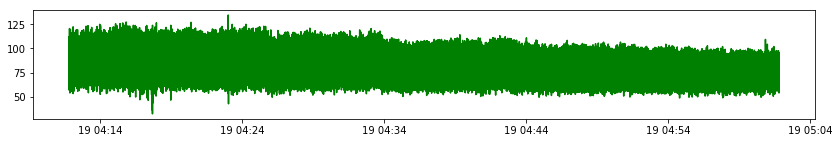

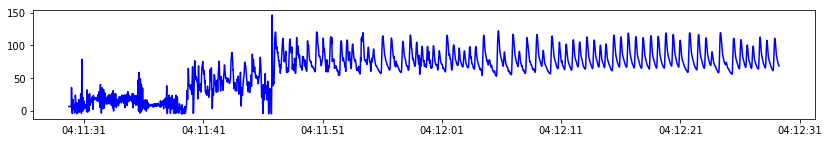

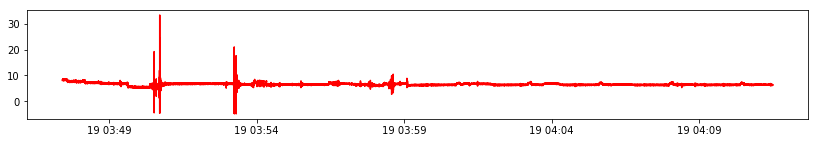

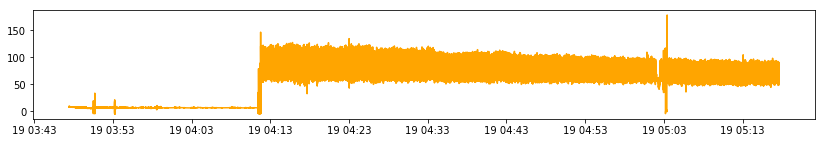

In [88]:
num = 5000

waveform_data = waveforms.head(num)
vitals_data = vitals.head(num)

abp_signal_whole = AR2_data
abp_signal_ideal = AR2_data.iloc[350860:1071000] #waveform_data['AR2'] 357000:1071000
abp_signal_poor = AR2_data.iloc[:346700] #100000
abp_signal_hectic = AR2_data.iloc[346700:360860]

# abp_segment = pd.DataFrame({"AR1": AR2_data.values})
# abp_segment = pd.DataFrame(AR2_data)
# abp_segment.rename(index=str, columns={"AR1": "AR2"})
# print(abp_segment.head(5))

# vitals_signal = vitals_data['AR2-M'] #waveform_data['V']
# ecg_signal = waveform_data['I']

plt.figure(num=1, figsize=(14, 2))
plt.plot(abp_signal_ideal, color='green')

plt.figure(num=2, figsize=(14, 2))
plt.plot(abp_signal_hectic, color='blue')

plt.figure(num=3, figsize=(14, 2))
plt.plot(abp_signal_poor, color='red')

plt.figure(num=4, figsize=(14, 2))
plt.plot(abp_signal_whole, color='orange')

# print(isinstance(abp_signal_ideal, pd.Series))

plt.show()

In [32]:
waveform_processor = ABPWaveformProcessor()

df_ideal = waveform_processor.processWaveform(abp_signal_ideal, 5, 1, "AR2")
df_poor = waveform_processor.processWaveform(abp_signal_poor, 5, 1, "AR2")
df_hectic = waveform_processor.processWaveform(abp_signal_hectic, 5, 1, "AR2")

In [74]:
colors = ["red", "olive", "darkred", "goldenrod", "skyblue", "orange", "salmon"]

p1 = figure(plot_width=600, plot_height=300, title="Detail Number vs Energy Coefficients")
p2 = figure(plot_width=600, plot_height=300, title="Average Number vs Energy Coefficients")

for color, data in zip(["red", "goldenrod", "skyblue"], [df_ideal, df_poor, df_hectic]):
    data = data.head(5)
#    print(data)
    for i, coeffs in enumerate(data):
#         print(coeffs)
        for value in data[coeffs]:
#             print(value)
            y = value
            #color = colors[i % len(colors)]

            if "cD" in coeffs: 
                p1.circle(x=i, y=y, color=color)
            else:
                p2.circle(x=i, y=y, color=color)
                #{'value': i, 'transform': Jitter(width=1)}

# output_file("jitter.html")

output_notebook()

show(column(p1,p2), notebook_handle=True)

Loading BokehJS ...

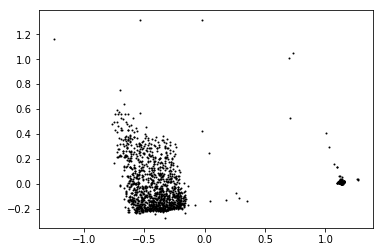

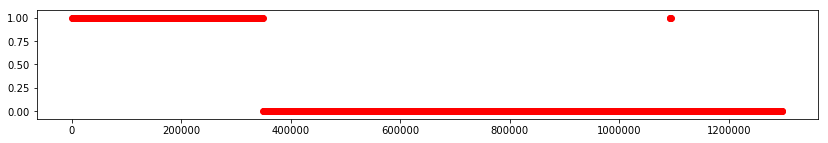

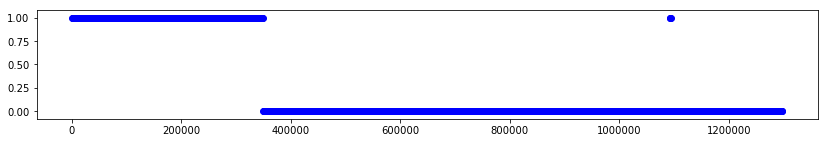

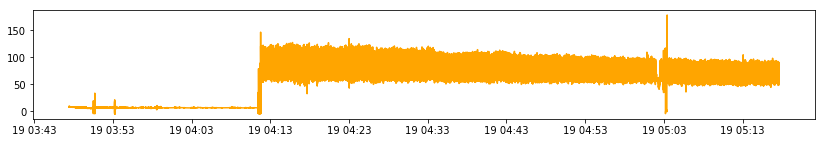

In [87]:
df_whole = waveform_processor.processWaveform(abp_signal_whole, 5, 1, "AR2")

min_max_scaler = preprocessing.MinMaxScaler()
abp_train_minmax = min_max_scaler.fit_transform(df_whole)

n_samples, n_features = abp_train_minmax.shape #1622, 10
n_digits = 2
n_targets = ['0', '1']

cluster_data = KMeans(n_clusters=n_digits).fit_predict(abp_train_minmax)

reduced_data = PCA(n_components=2).fit_transform(abp_train_minmax)

pca_kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10).fit_predict(reduced_data)

plt.figure(1)
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

plt.figure(2, figsize=(14, 2))
plt.scatter(waveform_processor.segmenter(abp_signal_whole)[1:], cluster_data, color='red')

plt.figure(3, figsize=(14, 2))
plt.scatter(waveform_processor.segmenter(abp_signal_whole)[1:], pca_kmeans, color='blue')

plt.figure(num=4, figsize=(14, 2))
plt.plot(abp_signal_whole, color='orange')

plt.show()

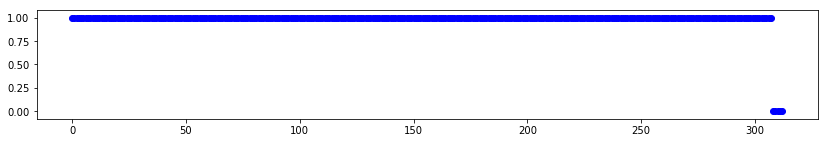

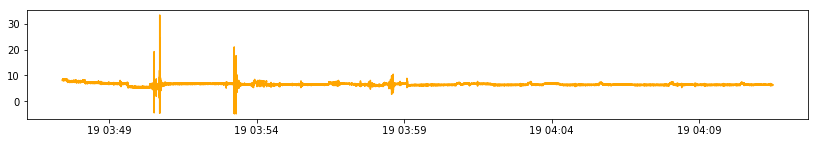

In [86]:
min_max_scaler = preprocessing.MinMaxScaler()
abp_train_poor = min_max_scaler.fit_transform(df_poor)

reduced_data_poor = PCA(n_components=2).fit_transform(abp_train_poor)

reduced_kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10).fit(reduced_data)
reduced_kmeans_poor = reduced_kmeans.predict(reduced_data_poor)

plt.figure(5, figsize=(14, 2))
plt.scatter(np.arange(0,313), reduced_kmeans_poor, color='blue')

plt.figure(num=6, figsize=(14, 2))
plt.plot(abp_signal_poor, color='orange')
plt.show()